In [1]:
import os
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import random
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000000

### HistoQC filtered

In [2]:
HistoQC = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Outputs/group_scratch_Outputs/HistoQC_results.csv")
HistoQC_filtered = HistoQC.dropna()
HistoQC_filtered["Patient"] = HistoQC_filtered["filename"].str.split('-', n=4).str[:4].str.join('-')
HistoQC_filtered = HistoQC_filtered[["Patient","filename",
                                     "blurry_removed_percent","pixels_to_use","small_tissue_removed_num_regions"]]

# Filtering criteria=================================
blurry_removed_percent_files = set(HistoQC_filtered[HistoQC_filtered["blurry_removed_percent"]>0.9].sort_values(["blurry_removed_percent"])["filename"])
pixels_to_use_files = set(HistoQC_filtered[HistoQC_filtered["pixels_to_use"]<np.percentile(HistoQC_filtered["pixels_to_use"],5)].sort_values(["pixels_to_use"])["filename"])
small_tissue_removed_num_regions_files = set(HistoQC_filtered[HistoQC_filtered["small_tissue_removed_num_regions"]>np.percentile(HistoQC_filtered["small_tissue_removed_num_regions"],97.5)].sort_values(["small_tissue_removed_num_regions"])["filename"])

# Apply Filtering =================================
exclude_set = set(blurry_removed_percent_files | pixels_to_use_files | small_tissue_removed_num_regions_files)
HistoQC_filtered_params = HistoQC_filtered[~HistoQC_filtered['filename'].isin(exclude_set)]
# HistoQC_filtered_params.to_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Outputs/group_scratch_Outputs/HistoQC_filtered.csv")
bad_images = HistoQC_filtered[~HistoQC_filtered["filename"].isin(HistoQC_filtered_params["filename"])]

#Old Filtering =================================
# HistoQC_filtered = HistoQC[(HistoQC["background_contrast"]<=0.5) & (HistoQC["blurry_removed_percent"]<=0.8) & (HistoQC["blurry_removed_mean_area"]<=0.2e6) & (HistoQC["background_grayscale_brightness"] >= 0.8)]

In [2]:
import random
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000000
sample_files = HistoQC_filtered['filename'].sample(25, random_state=42).tolist()
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    file_path = "/QRISdata/Q2051/Xiao/TCGA/Xiao/TCGA_svs/" + sample_files[i]
    img = Image.open(file_path).resize((250, 250))
    ax.imshow(img)
    ax.axis("off") 
plt.tight_layout()
plt.show()

In [1]:
import random
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = 933120000000
sample_files = bad_images['filename'].sample(25, random_state=42).tolist()
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    file_path = "/QRISdata/Q2051/Xiao/TCGA/Xiao/TCGA_svs/" + sample_files[i]
    img = Image.open(file_path).resize((250, 250))
    ax.imshow(img)
    ax.axis("off") 
plt.tight_layout()
plt.show()

### Functions to read the files and match patient's survival data

In [3]:
# Path_old = "/QRISdata/Q2051/STimage_project/TCGA_pred/"
Path = "/QRISdata/Q2051/STimage_project/TCGA_pred_selected/"
# Path = "/QRISdata/Q2051/Xiao/TCGA/Xiao/TCGA_results_FSTimage/"

def get_filenames_in_directory(directory_path):
    h5_filenames = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".h5ad") and os.path.isfile(os.path.join(directory_path, filename)):
            h5_filenames.append(filename)
    return h5_filenames

def TCGA_name(original_array):
    result_array = []
    for item in original_array:
        parts = item.split("_")
        if len(parts) >= 2:
            second_part = parts[1].split(".")[0]
            result_array.append(second_part)
    pattern1 = re.compile(r'-\d+-\w+$')
    pattern2 = re.compile(r'(.+)-\w+-\d+-\w+$')
    name_info = [re.sub(pattern1, '', s) for s in result_array]
    name_surv_info = [re.sub(pattern2, r'\1', s) for s in result_array]   
    return name_info, name_surv_info

filenames = get_filenames_in_directory(Path)
name_info, name_surv_info = TCGA_name(filenames)

### Subtype

In [4]:
brca_meta = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/BRCA.clin.merged.txt", 
                         sep="\t", header=None, dtype=str, keep_default_na=False)
brca_meta = brca_meta.T
brca_meta.columns = brca_meta.iloc[0]
brca_meta = brca_meta[1:]
brca_meta = brca_meta.astype(str)
brca_meta["her2"] = brca_meta["patient.lab_proc_her2_neu_immunohistochemistry_receptor_status"].apply(
    lambda x: "Her2+" if x == "positive" else "Others")
Her2_samples = brca_meta.loc[brca_meta["her2"] == "Her2+", "patient.bcr_patient_barcode"].dropna().str.upper().unique()

# Define subtype
brca_meta["subtype"] = brca_meta.apply(
    lambda row: "Her2" if row["patient.lab_proc_her2_neu_immunohistochemistry_receptor_status"] == "positive" else
                "TNBC" if (row["patient.lab_proc_her2_neu_immunohistochemistry_receptor_status"] == "negative" and
                           row["patient.breast_carcinoma_estrogen_receptor_status"] == "negative" and
                           row["patient.breast_carcinoma_progesterone_receptor_status"] == "negative") else
                "Luminal" if ((row["patient.breast_carcinoma_estrogen_receptor_status"] == "positive" and
                               row["patient.breast_carcinoma_progesterone_receptor_status"] == "positive") or
                              (row["patient.breast_carcinoma_estrogen_receptor_status"] == "positive" and
                               row["patient.breast_carcinoma_progesterone_receptor_status"] == "negative")) else
                "Other", axis=1)

brca_meta = brca_meta[["patient.bcr_patient_barcode", "subtype"]]
brca_meta["patient.bcr_patient_barcode"] = brca_meta["patient.bcr_patient_barcode"].str.upper()
her2_patients = list(set(brca_meta[brca_meta['subtype']=='Her2']['patient.bcr_patient_barcode']))
Luminal_patients = list(set(brca_meta[brca_meta['subtype']=='Luminal']['patient.bcr_patient_barcode']))
TNBC_patients = list(set(brca_meta[brca_meta['subtype']=='TNBC']['patient.bcr_patient_barcode']))
Other_patients = list(set(brca_meta[brca_meta['subtype']=='Other']['patient.bcr_patient_barcode']))

### Get the predicted and bulk expression for each gene each patient in csv file

In [3]:
final_gene_counts = pd.DataFrame()
final_gene_mean_counts = pd.DataFrame()
for i in tqdm(range(len(filenames)), desc="Processing files"):
    try:
        adata = sc.read_h5ad(Path + filenames[i])
        gene_counts = adata.to_df()
        gene_counts.index = [name_info[i]] * len(gene_counts)
        gene_counts_mean = pd.DataFrame(gene_counts.mean(axis=0))
        final_gene_counts = pd.concat([final_gene_counts, gene_counts])
        final_gene_mean_counts = pd.concat([final_gene_mean_counts, gene_counts_mean.T])
        final_gene_mean_counts.index = name_info[i]
    except:
        print("File empty:",Path + filenames[i])

final_gene_counts.to_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_final_gene_counts.csv")
final_gene_mean_counts.to_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_final_gene_mean_counts.csv")

#############################################################################################################################

survival_info = pd.read_excel("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/STimage_TCGA_patients.xlsx")
sample_info = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/gdc_sample_sheet.2024-01-24.tsv",sep="\t")

survival_info = survival_info[survival_info["case_submitter_id"].isin(name_surv_info)]
sample_info = sample_info[sample_info["Sample ID"].isin(name_info)]

##############################################################################################################################

final_gene_mean_counts = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_final_gene_mean_counts.csv",index_col=0)
final_gene_mean_counts.index = name_info

all_bulk_ge = pd.DataFrame()
for i in tqdm(range(len(sample_info)), desc="Processing bulk gene expression files"):
    try:
        bulk_ge = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/" + list(sample_info["File Name"])[i],
                              sep="\t", skiprows=1)
        bulk_ge = bulk_ge.iloc[4:, :]
        bulk_ge = bulk_ge.set_index("gene_name")
        bulk_ge = bulk_ge[["tpm_unstranded"]]
        bulk_ge.rename(columns={'tpm_unstranded': name_info[i]}, inplace=True)
        bulk_ge = bulk_ge[bulk_ge.index.isin(list(final_gene_mean_counts.columns))]
        all_bulk_ge = pd.concat([all_bulk_ge, bulk_ge], axis=1)
    except:
        print("File empty:",Path + list(sample_info["File Name"])[i])


import tarfile
import pandas as pd
from tqdm import tqdm

# Initialize an empty DataFrame
all_bulk_ge = pd.DataFrame()

# Path to your tar.gz file
tar_gz_path = "/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/STimage_TCGA_tsv_ge.tar.gz"

# Open the tar.gz archive
with tarfile.open(tar_gz_path, "r:gz") as tar:
    file_names = tar.getnames()
    
    for i in tqdm(range(len(sample_info)), desc="Processing bulk gene expression files"):
        try:
            file_name = list(sample_info["File Name"])[i]            
            if file_name in file_names:
                file_obj = tar.extractfile(file_name)
                bulk_ge = pd.read_csv(file_obj, sep="\t", skiprows=1)
                bulk_ge = bulk_ge.iloc[4:, :]
                bulk_ge = bulk_ge.set_index("gene_name")
                bulk_ge = bulk_ge[["tpm_unstranded"]]
                bulk_ge.rename(columns={'tpm_unstranded': name_info[i]}, inplace=True)
                bulk_ge = bulk_ge[bulk_ge.index.isin(list(final_gene_mean_counts.columns))]
                all_bulk_ge = pd.concat([all_bulk_ge, bulk_ge], axis=1)
            else:
                print(f"File not found in archive: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")



import tarfile
import pandas as pd
from tqdm import tqdm

# Initialize an empty DataFrame
all_bulk_ge = pd.DataFrame()
tar_gz_path = "/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/STimage_TCGA_tsv_ge.tar.gz"
with tarfile.open(tar_gz_path, "r:gz") as tar:
    tsv_files = {member.name: member for member in tar.getmembers() if member.name.endswith(".tsv")}
for i in tqdm(range(len(sample_info)), desc="Processing bulk gene expression files"):
    try:
        file_name = list(sample_info["File Name"])[i]        
        if file_name in tsv_files:
            with tarfile.open(tar_gz_path, "r:gz") as tar:
                file_obj = tar.extractfile(tsv_files[file_name])
                bulk_ge = pd.read_csv(file_obj, sep="\t", skiprows=1)                
                bulk_ge = bulk_ge.iloc[4:, :]
                bulk_ge = bulk_ge.set_index("gene_name")
                bulk_ge = bulk_ge[["tpm_unstranded"]]
                bulk_ge.rename(columns={'tpm_unstranded': name_info[i]}, inplace=True)
                bulk_ge = bulk_ge[bulk_ge.index.isin(list(final_gene_mean_counts.columns))]                
                all_bulk_ge = pd.concat([all_bulk_ge, bulk_ge], axis=1)
        else:
            print(f"File not found in archive: {file_name}")
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")


##############################################################################################################################

survival_info = survival_info[["case_id","case_submitter_id",
                               "vital_status","days_to_last_follow_up",
                               "days_to_death","ajcc_pathologic_stage"]]
survival_info["time"] = np.where(survival_info["vital_status"]=="Alive",survival_info["days_to_last_follow_up"],survival_info["days_to_death"])
survival_info = survival_info[["case_id","case_submitter_id","time",
                               "vital_status","ajcc_pathologic_stage"]]
survival_info.to_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_survival_info.csv")

### Perform Correlation between bulk and predicted

In [5]:
all_bulk_ge = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_bluk_ge.csv",index_col=0)
all_bulk_ge = all_bulk_ge.loc[:,list(set(all_bulk_ge.columns).intersection(set(HistoQC_filtered_params["Patient"])))]
final_gene_mean_counts = pd.read_csv("/QRISdata/Q2051/Onkar/STimage/project_scratch_STimage/STimage_v1/Survival/Updated3_final_gene_mean_counts.csv",
                                     index_col=0)
final_gene_mean_counts.index = name_info

# Take the average if 1 patient has 2 RNA-Seq runs 
all_bulk_ge.columns = all_bulk_ge.columns.str.split('.').str[0]
all_bulk_ge = all_bulk_ge.groupby(all_bulk_ge.columns, axis=1).mean()

# Remove duplicate genes with 0s
all_bulk_ge = all_bulk_ge[~((all_bulk_ge.index.duplicated(keep=False)) & (all_bulk_ge.eq(0).all(axis=1)))]
all_bulk_ge = all_bulk_ge.reindex(final_gene_mean_counts.columns)

##############################################################################################################################

# Subset the dataframe to the patients for which we have RNA-seq and rearrange the columns and rows
final_gene_mean_counts = final_gene_mean_counts[final_gene_mean_counts.index.isin(all_bulk_ge.columns)].T.sort_index(axis=1)
column_names_list = list(final_gene_mean_counts.columns)
column_counts = {col: column_names_list.count(col) for col in set(column_names_list)}
for col, count in column_counts.items():
    for i in range(1, count):
        new_col_name = f"{col}_{i + 1}"
        all_bulk_ge[new_col_name] = all_bulk_ge[col]
all_bulk_ge.columns = all_bulk_ge.columns.str.split('_').str[0]
all_bulk_ge = all_bulk_ge.sort_index(axis=1)

In [6]:
# Calculate Pearson correlation coefficients and p-values for each pair of columns
correlation_data = []
for col in range(len(final_gene_mean_counts.columns)):
    corr_coeff, p_value = pearsonr(final_gene_mean_counts.iloc[:, col], all_bulk_ge.iloc[:, col])
    correlation_data.append({'Column': f'{final_gene_mean_counts.columns[col]} vs {all_bulk_ge.columns[col]}', 'Correlation Coefficient': corr_coeff, 'P-Value': p_value})

# Convert the correlation data to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Print correlation coefficients and p-values
print("Pearson Correlation Coefficients and P-Values:")
print(correlation_df)
correlation_df["PCC"] = "PCC"

# Create scatterplots for each pair of columns using sns.lmplot
for col in range(len(final_gene_mean_counts.columns)):
    data = pd.DataFrame({f'{final_gene_mean_counts.columns[col]} (final_gene_mean_counts)': final_gene_mean_counts.iloc[:, col], f'{all_bulk_ge.columns[col]} (all_bulk_ge)': all_bulk_ge.iloc[:, col]})    
    corr_coeff = correlation_df.loc[col, 'Correlation Coefficient']
    p_value = correlation_df.loc[col, 'P-Value']
print("=======================================================")
print("Mean Correlation Coefficient: ", correlation_df["Correlation Coefficient"].mean())

Pearson Correlation Coefficients and P-Values:
                                    Column  Correlation Coefficient  \
0     TCGA-3C-AALI-01A vs TCGA-3C-AALI-01A                 0.423100   
1     TCGA-3C-AALJ-01A vs TCGA-3C-AALJ-01A                 0.533504   
2     TCGA-5L-AAT0-01A vs TCGA-5L-AAT0-01A                 0.419272   
3     TCGA-5T-A9QA-01A vs TCGA-5T-A9QA-01A                 0.663723   
4     TCGA-A1-A0SB-01A vs TCGA-A1-A0SB-01A                 0.402480   
...                                    ...                      ...   
1029  TCGA-S3-AA11-01A vs TCGA-S3-AA11-01A                 0.573091   
1030  TCGA-S3-AA15-01A vs TCGA-S3-AA15-01A                 0.593404   
1031  TCGA-W8-A86G-01A vs TCGA-W8-A86G-01A                 0.386938   
1032  TCGA-WT-AB41-01A vs TCGA-WT-AB41-01A                 0.542876   
1033  TCGA-XX-A899-01A vs TCGA-XX-A899-01A                 0.404401   

            P-Value  
0      3.788564e-67  
1     1.066582e-112  
2      7.523007e-66  
3     6.3089

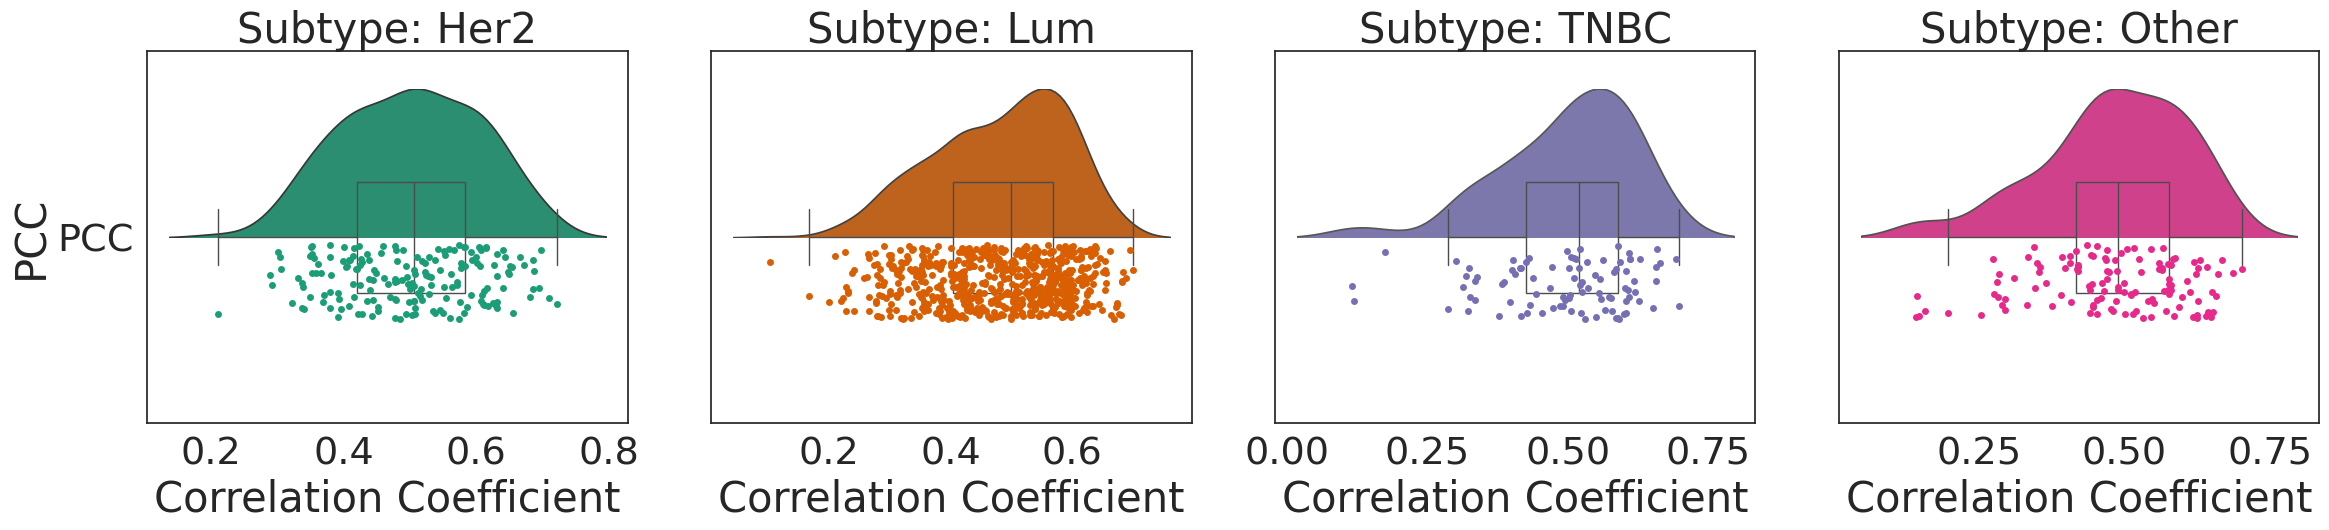

In [7]:
correlation_df["Patient"] = correlation_df["Column"].str.split(" ").str[0].str.split('-').str[:-1].str.join('-')
correlation_df["subtype"] = np.where(correlation_df["Patient"].isin(her2_patients),"Her2", 
                                     np.where(correlation_df["Patient"].isin(Luminal_patients),"Lum",
                                              np.where(correlation_df["Patient"].isin(TNBC_patients),"TNBC","Other")))

sns.set(font_scale=2.5)
sns.set_style('white')

subtypes = ["Her2","Lum","TNBC","Other"]#correlation_df['subtype'].unique()
n_subtypes = len(subtypes)
palette = sns.color_palette("Dark2", n_subtypes)  # Use a distinct color palette
fig, axes = plt.subplots(nrows=1, ncols=n_subtypes, figsize=(6 * n_subtypes, 6), sharey=True)

if n_subtypes == 1:
    axes = [axes]
for i, subtype in enumerate(subtypes):
    ax = axes[i]
    subset_df = correlation_df[correlation_df['subtype'] == subtype]
    sns.violinplot(y="PCC", x="Correlation Coefficient", data=subset_df,
                   color=palette[i], scale="width", inner=None, ax=ax)
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

    sns.boxplot(y="PCC", x="Correlation Coefficient", data=subset_df,
                saturation=1, showfliers=False, width=0.3,
                boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)

    old_len_collections = len(ax.collections)
    sns.stripplot(y="PCC", x="Correlation Coefficient", data=subset_df,
                  color=palette[i], ax=ax, dodge=True)

    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))

    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.set_title(f'Subtype: {subtype}')

handles, labels = ax.get_legend_handles_labels()
if handles:  # Only add legend if there are handles
    fig.legend(handles[:len(set(labels))], labels[:len(set(labels))], title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/scratch/project/stseq/Onkar/BigData/STimage_outputs/STimage_TCGA-PCC_Subtype.pdf', format='pdf', dpi=400)
plt.show()

In [22]:
correlation_df["subtype"].value_counts()

subtype
Lum      636
Her2     182
Other    123
TNBC      93
Name: count, dtype: int64

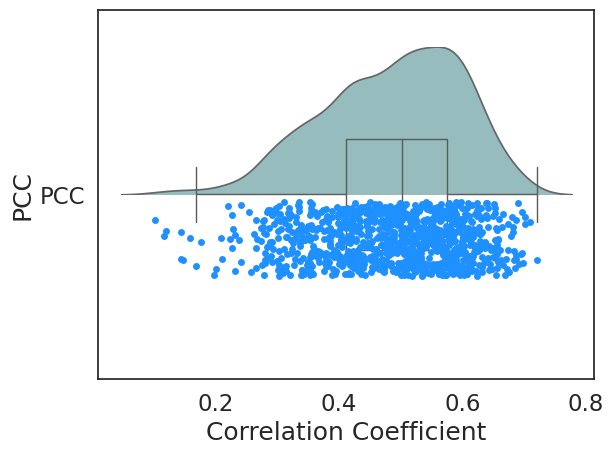

In [8]:
sns.set(font_scale=1.5)
sns.set_style('white')
palette = sns.cubehelix_palette(start=.5, rot=-.5, dark=0.3, light=0.7)
ax = sns.violinplot(y="PCC", x="Correlation Coefficient", data=correlation_df,
                    palette=palette,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="PCC", x="Correlation Coefficient", data=correlation_df, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(y="PCC", x="Correlation Coefficient", data=correlation_df, color='dodgerblue', ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.savefig('/scratch/project/stseq/Onkar/BigData/STimage_outputs/STimage_TCGA-PCC_ALL.pdf', format='pdf', dpi=400)
plt.show()
correlation_df.to_csv("/scratch/project/stseq/Onkar/BigData/STimage_outputs/STimage_TCGA-PCC.csv")

In [9]:
# correlation_df = pd.read_csv("/scratch/project/stseq/Onkar/BigData/STimage_outputs/STimage_TCGA-PCC.csv")
len(set(correlation_df["Patient"]))

670

In [9]:
print("Original", len(correlation_df))
print("Filtered", len(correlation_df[correlation_df["P-Value"]<0.01]))

Original 1034
Filtered 1034


In [74]:
all_bulk_ge_t_logged.index = "True_"+all_bulk_ge_t_logged.index
final_gene_mean_counts_t.index = "Predicted_"+final_gene_mean_counts_t.index
df = pd.concat([final_gene_mean_counts_t,all_bulk_ge_t_logged])

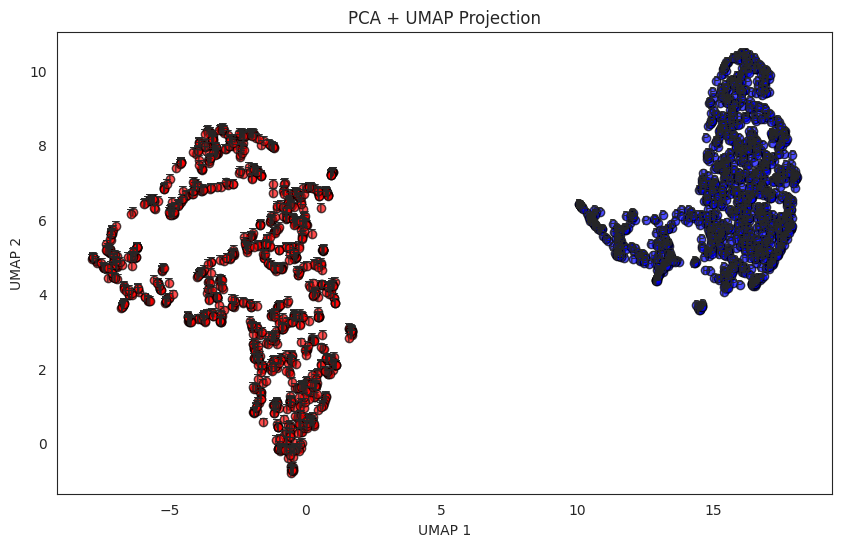

array([[16.640898  ,  7.2873473 ],
       [17.250662  ,  7.0958133 ],
       [16.304756  ,  9.079434  ],
       ...,
       [-1.7475334 ,  2.291137  ],
       [-1.1169941 ,  5.7218823 ],
       [-0.19415474,  0.75587785]], dtype=float32)

In [75]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_pca_umap(df, n_components_pca=10, n_components_umap=2, random_state=42):

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Run PCA
    pca = PCA(n_components=n_components_pca, random_state=random_state)
    pca_result = pca.fit_transform(df_scaled)
    
    # Run UMAP
    umap_model = umap.UMAP(n_components=n_components_umap, random_state=random_state)
    umap_result = umap_model.fit_transform(pca_result)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    
    for i, idx in enumerate(df.index):
        label = idx[0]
        color = 'red' if label == 'T' else 'blue'
        plt.scatter(umap_result[i, 0], umap_result[i, 1], color=color, alpha=0.7, edgecolors='k')
        plt.text(umap_result[i, 0], umap_result[i, 1], label, fontsize=9, ha='center', va='center')
    
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('PCA + UMAP Projection')
    plt.show()
    
    return umap_result

run_pca_umap(df)

In [76]:
from combat.pycombat import pycombat
batch = list(df.index.str[0])
data_corrected = pycombat(df.T,batch)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


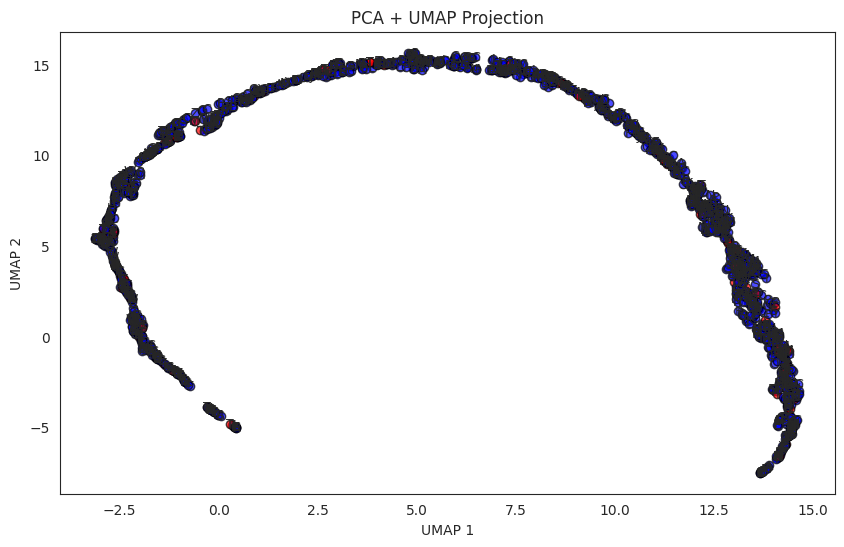

array([[14.30384  , -5.462298 ],
       [ 8.848726 , 13.722596 ],
       [ 4.419748 , 15.036452 ],
       ...,
       [ 7.43296  , 14.77394  ],
       [12.759911 ,  5.4244156],
       [ 6.507918 , 14.751313 ]], dtype=float32)

In [77]:
df_batch_corrected = data_corrected.T
run_pca_umap(data_corrected)

In [86]:
predicted_corrected = data_corrected.T.iloc[:1191,:]
true_corrected = data_corrected.T.iloc[1191:,:]

In [96]:
predicted_corrected = library_size_normalization(predicted_corrected.T).T
true_corrected = library_size_normalization(true_corrected.T).T

In [97]:
correlation_genes_corrected = []

for col in range(len(predicted_corrected.columns)):
    corr_coeff, p_value = pearsonr(predicted_corrected.iloc[:, col], true_corrected.iloc[:, col])
    correlation_genes_corrected.append({'Column': f'{predicted_corrected.columns[col]} vs {true_corrected.columns[col]}', 'Correlation Coefficient': corr_coeff, 'P-Value': p_value})

# Convert the correlation data to a DataFrame
correlation_genes_df_corrected = pd.DataFrame(correlation_genes_corrected)

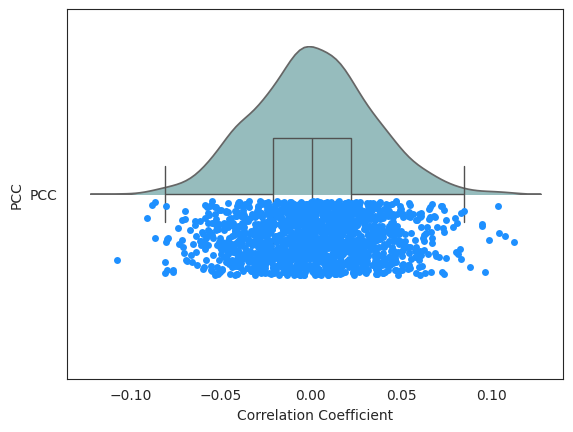

In [98]:
sns.set_style('white')
palette = sns.cubehelix_palette(start=.5, rot=-.5, dark=0.3, light=0.7)
correlation_genes_df_corrected["PCC"] = "PCC"
ax = sns.violinplot(y="PCC", x="Correlation Coefficient", data=correlation_genes_df_corrected,
                    palette=palette,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="PCC", x="Correlation Coefficient", data=correlation_genes_df_corrected, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(y="PCC", x="Correlation Coefficient", data=correlation_genes_df_corrected, color='dodgerblue', ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# plt.savefig('/scratch/project/stseq/Onkar/BigData/STimage_outputs/TCGA-PCC_genes.png', format='png', dpi=400)
plt.show()
# correlation_genes_df.to_csv("/scratch/project/stseq/Onkar/BigData/STimage_outputs/TCGA-PCC_genes.csv")

In [92]:
predicted_corrected

,ISG15,TNFRSF18,TNFRSF4,CALML6,HES5,TNFRSF14,TNFRSF25,TNFRSF9,ERRFI1,PIK3CD,...,CD40LG,FGF13,SPANXB1,MAGEA4,MAGEA12,IRAK1,FLNA,DNASE1L1,G6PD,IKBKG
Predicted_TCGA-3C-AALI-01A,1737.515834,495.254849,377.698137,125.854997,100.605984,805.590822,373.428516,168.912816,864.413791,386.483423,...,171.832807,224.898197,112.223662,112.646575,111.623094,1306.681267,2248.586559,487.449521,751.005867,418.047373
Predicted_TCGA-3C-AALJ-01A,1705.494298,479.898118,412.071807,125.534621,100.932808,814.423187,413.786609,171.704392,826.629582,399.547887,...,172.171985,235.863110,113.357737,122.774151,113.597560,1215.109374,2438.722579,460.758079,756.641469,442.238916
Predicted_TCGA-5L-AAT0-01A,1651.412749,483.933782,415.891349,126.008817,102.072296,717.089222,394.294934,170.731739,889.398899,396.871352,...,175.211960,247.791821,114.247253,143.166035,115.590903,1195.031700,2356.722525,455.496522,746.708997,431.939269
Predicted_TCGA-5T-A9QA-01A,2469.110236,529.072522,444.291544,125.915166,101.024432,880.150832,419.314816,178.583313,719.879107,395.338137,...,173.970483,212.661102,113.295014,115.542509,112.491225,1273.015890,2103.504520,505.443067,790.955783,525.971186
Predicted_TCGA-A1-A0SB-01A,1946.525414,523.929170,401.947695,125.246843,101.193237,823.452097,400.765221,168.550755,804.749154,392.921505,...,172.726387,218.137510,112.145675,113.742289,111.715857,1259.442616,2262.508616,474.642356,768.907178,450.116543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Predicted_TCGA-S3-AA15-01A,1803.870862,504.037182,441.751062,125.741970,101.983013,866.657062,430.126666,173.329078,825.662336,397.632194,...,176.159983,233.237443,115.968190,167.394387,120.167914,1274.666191,2332.426746,483.568938,754.118669,434.442177
Predicted_TCGA-W8-A86G-01A,1816.758679,508.333175,378.016918,125.455590,100.942952,745.800295,382.604755,166.957555,811.062317,394.904571,...,171.909582,236.614937,112.098575,121.958280,112.420698,1321.367637,2475.296131,472.743167,777.784763,453.731253
Predicted_TCGA-WT-AB41-01A,2203.670421,515.457180,441.619372,125.132405,101.208625,917.356152,421.448220,174.961212,781.375667,397.541915,...,173.913898,212.974596,112.921418,155.983194,116.501349,1365.233944,2191.893270,507.476685,768.938833,448.415297
Predicted_TCGA-WT-AB44-01A,2073.950524,500.502538,389.744751,124.372200,101.814351,681.182589,368.714124,165.031825,845.066403,407.368175,...,174.254081,229.048804,112.050176,174.882444,115.683954,1332.715566,2599.723726,430.259786,790.682822,487.122327


In [91]:
true_corrected

,ISG15,TNFRSF18,TNFRSF4,CALML6,HES5,TNFRSF14,TNFRSF25,TNFRSF9,ERRFI1,PIK3CD,...,CD40LG,FGF13,SPANXB1,MAGEA4,MAGEA12,IRAK1,FLNA,DNASE1L1,G6PD,IKBKG
True_TCGA-3C-AALI-01A,2551.876715,731.105391,421.063305,127.322134,103.762018,820.093790,353.827522,159.225703,871.304856,346.313074,...,146.007480,276.506791,101.650613,116.218504,241.789116,1597.474721,2124.602865,519.379773,840.081337,539.210518
True_TCGA-3C-AALJ-01A,1825.831421,398.996751,399.212146,108.411868,106.002830,721.795116,335.849857,170.955308,741.117336,405.700929,...,150.261958,272.106969,90.408799,103.656169,91.009172,1166.699603,2254.827077,483.544887,721.888547,420.820308
True_TCGA-5L-AAT0-01A,1930.027150,466.440104,420.270770,113.132395,96.788458,799.903587,377.015898,176.047036,766.111633,412.591676,...,240.432462,281.743143,89.025372,146.613963,372.593043,1220.823373,2186.238440,465.139433,785.039247,447.360901
True_TCGA-5T-A9QA-01A,2546.216098,552.676761,390.956673,123.834023,99.677721,1012.307769,376.241033,194.678266,783.144436,406.458697,...,193.002123,211.314170,104.098859,109.945350,96.820709,1478.726964,2274.547134,493.096309,781.573049,444.491546
True_TCGA-A1-A0SB-01A,1415.599423,489.180080,409.798649,108.476235,96.481864,771.903810,363.385048,213.146022,735.258683,414.716508,...,235.642460,193.634406,123.491083,109.008193,94.115790,1016.486126,2113.159163,436.614648,727.911311,381.711119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
True_TCGA-S3-AA15-01A,1725.110220,420.555410,449.861600,107.828457,100.334177,771.171008,506.681067,173.917265,969.289705,425.385091,...,167.288940,183.096891,91.836432,105.251498,94.856583,1711.857883,2356.147269,438.438125,779.888965,479.624198
True_TCGA-W8-A86G-01A,1768.178677,465.008158,447.991475,129.683936,102.211326,1111.125862,465.318285,146.526610,906.036438,334.766574,...,147.081751,241.672649,164.014477,113.802444,100.384868,1483.420890,2175.119601,541.999758,830.573258,560.452558
True_TCGA-WT-AB41-01A,2662.728742,508.958241,380.637405,141.801829,103.816165,935.627982,368.558407,192.438056,810.018796,385.045162,...,178.570646,185.270323,94.055581,107.731320,94.774828,1404.600246,2133.179031,494.356529,754.175605,503.159635
True_TCGA-WT-AB44-01A,2266.215315,631.002889,433.417226,179.608268,110.718414,1126.325805,536.762203,150.353971,788.636030,378.182003,...,185.363035,213.310572,99.419697,113.725534,100.313799,1127.152902,2074.065883,454.346080,751.415766,382.153017
